In [9]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## Load Results from All Providers

In [10]:
def load_latest_results(provider):
    """Load the most recent comparison results for a provider."""
    reports_dir = Path(f'reports_{provider}')
    
    if not reports_dir.exists():
        return None
    
    # Find most recent JSON file
    json_files = list(reports_dir.glob('comparison_details_*.json'))
    if not json_files:
        return None
    
    latest = max(json_files, key=lambda p: p.stat().st_mtime)
    
    with open(latest, 'r') as f:
        return json.load(f)

def calculate_metrics(data):
    """Calculate key metrics from comparison data."""
    if not data:
        return None
    
    total = len(data)
    original_compiled = sum(1 for d in data if d['original_compilation']['compiled'])
    refactored_compiled = sum(1 for d in data if d['refactored_compilation']['compiled'])
    both_compiled = sum(1 for d in data if d['original_compilation']['compiled'] and d['refactored_compilation']['compiled'])
    outputs_match = sum(1 for d in data if d.get('outputs_match') is True)
    
    return {
        'total': total,
        'original_compiled': original_compiled,
        'refactored_compiled': refactored_compiled,
        'both_compiled': both_compiled,
        'outputs_match': outputs_match,
        'original_pct': original_compiled / total * 100,
        'refactored_pct': refactored_compiled / total * 100,
        'both_pct': both_compiled / total * 100,
        'match_pct': outputs_match / both_compiled * 100 if both_compiled > 0 else 0
    }

# Load results for all providers
providers = ['openai', 'claude', 'groq', 'deepseek']
results = {}

for provider in providers:
    data = load_latest_results(provider)
    metrics = calculate_metrics(data)
    if metrics:
        results[provider] = metrics
        print(f"✓ Loaded {provider}: {metrics['refactored_compiled']}/{metrics['total']} compiled")
    else:
        # Use placeholder data if results not available yet
        print(f"⚠ No results for {provider} - using placeholder data")
        results[provider] = {
            'total': 76,
            'original_compiled': 41,
            'refactored_compiled': 0,
            'both_compiled': 0,
            'outputs_match': 0,
            'original_pct': 53.9,
            'refactored_pct': 0,
            'both_pct': 0,
            'match_pct': 0
        }

✓ Loaded openai: 33/76 compiled
✓ Loaded claude: 32/76 compiled
✓ Loaded groq: 27/73 compiled
⚠ No results for deepseek - using placeholder data


## Summary Table

In [11]:
# Create summary dataframe
df = pd.DataFrame(results).T
df_display = df[['original_compiled', 'refactored_compiled', 'both_compiled', 'outputs_match']].copy()
df_display.columns = ['Original Compiled', 'Refactored Compiled', 'Both Compiled', 'Outputs Match']

print("\n" + "="*80)
print("COMPILATION RESULTS BY PROVIDER")
print("="*80)
print(df_display.to_string())
print("\n")

# Percentage table
df_pct = df[['refactored_pct', 'match_pct']].copy()
df_pct.columns = ['Refactored Compile %', 'Output Match %']
print("\nPERCENTAGES:")
print(df_pct.round(1).to_string())


COMPILATION RESULTS BY PROVIDER
          Original Compiled  Refactored Compiled  Both Compiled  Outputs Match
openai                 41.0                 33.0           33.0           13.0
claude                 41.0                 32.0           32.0           14.0
groq                   40.0                 27.0           23.0            7.0
deepseek               41.0                  0.0            0.0            0.0



PERCENTAGES:
          Refactored Compile %  Output Match %
openai                    43.4            39.4
claude                    42.1            43.8
groq                      37.0            30.4
deepseek                   0.0             0.0


## Visualization 1: Compilation Success Rates

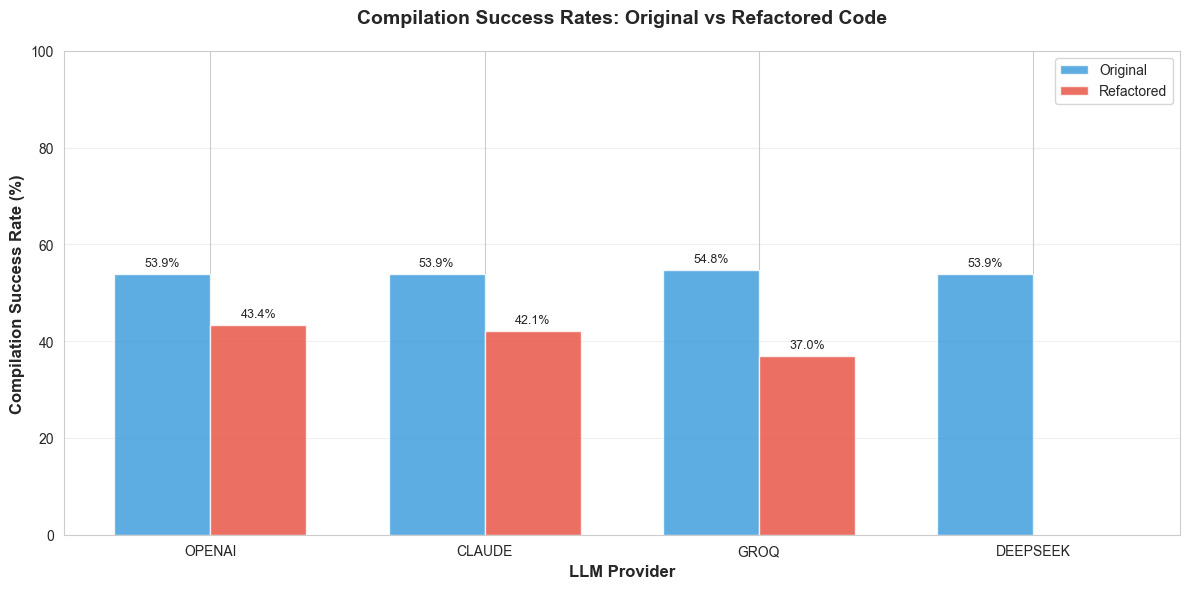

In [12]:
fig, ax = plt.subplots(figsize=(12, 6))

providers_list = list(results.keys())
x = range(len(providers_list))
width = 0.35

original = [results[p]['original_pct'] for p in providers_list]
refactored = [results[p]['refactored_pct'] for p in providers_list]

bars1 = ax.bar([i - width/2 for i in x], original, width, label='Original', color='#3498db', alpha=0.8)
bars2 = ax.bar([i + width/2 for i in x], refactored, width, label='Refactored', color='#e74c3c', alpha=0.8)

ax.set_xlabel('LLM Provider', fontsize=12, fontweight='bold')
ax.set_ylabel('Compilation Success Rate (%)', fontsize=12, fontweight='bold')
ax.set_title('Compilation Success Rates: Original vs Refactored Code', fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels([p.upper() for p in providers_list])
ax.legend()
ax.set_ylim(0, 100)
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width()/2., height + 1,
                   f'{height:.1f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

## Visualization 2: Output Correctness Rate

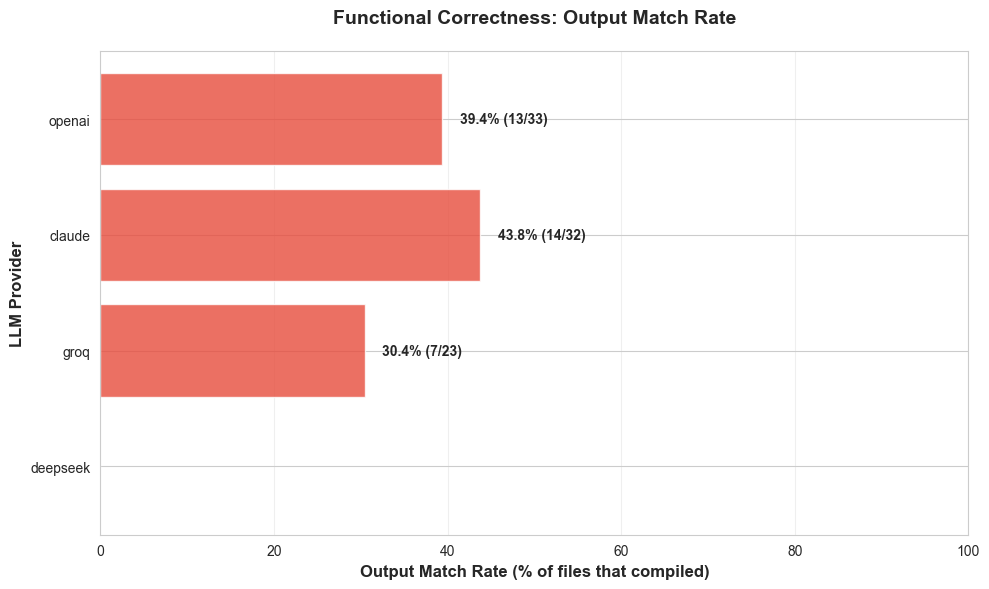

In [13]:
fig, ax = plt.subplots(figsize=(10, 6))

match_rates = [results[p]['match_pct'] for p in providers_list]
colors = ['#2ecc71' if rate > 70 else '#f39c12' if rate > 50 else '#e74c3c' for rate in match_rates]

bars = ax.barh(providers_list, match_rates, color=colors, alpha=0.8)

ax.set_xlabel('Output Match Rate (% of files that compiled)', fontsize=12, fontweight='bold')
ax.set_ylabel('LLM Provider', fontsize=12, fontweight='bold')
ax.set_title('Functional Correctness: Output Match Rate', fontsize=14, fontweight='bold', pad=20)
ax.set_xlim(0, 100)
ax.grid(axis='x', alpha=0.3)

# Reverse y-axis to show best at top
ax.invert_yaxis()

# Add value labels
for i, (bar, rate) in enumerate(zip(bars, match_rates)):
    if rate > 0:
        both = results[providers_list[i]]['both_compiled']
        matched = results[providers_list[i]]['outputs_match']
        ax.text(rate + 2, bar.get_y() + bar.get_height()/2,
               f'{rate:.1f}% ({matched}/{both})',
               va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

## Visualization 3: Success Pipeline (Stacked Bar Chart)

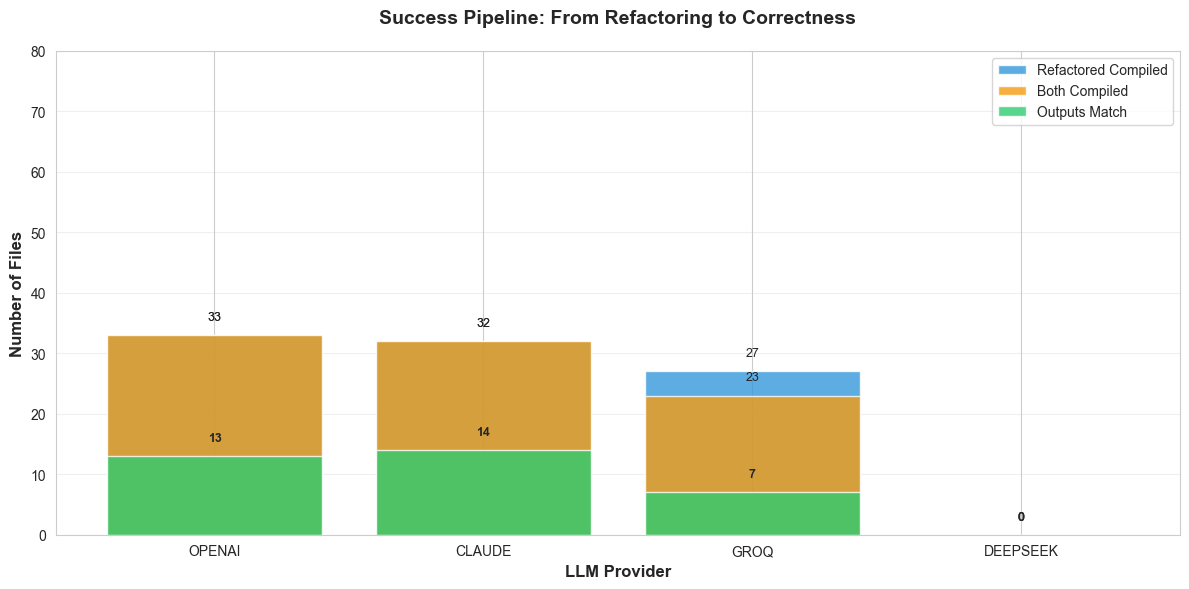

In [14]:
fig, ax = plt.subplots(figsize=(12, 6))

# Calculate stages
compiled = [results[p]['refactored_compiled'] for p in providers_list]
both = [results[p]['both_compiled'] for p in providers_list]
matched = [results[p]['outputs_match'] for p in providers_list]

# Stacked bars showing the pipeline
x = range(len(providers_list))

bars1 = ax.bar(x, compiled, label='Refactored Compiled', color='#3498db', alpha=0.8)
bars2 = ax.bar(x, both, label='Both Compiled', color='#f39c12', alpha=0.8)
bars3 = ax.bar(x, matched, label='Outputs Match', color='#2ecc71', alpha=0.8)

ax.set_xlabel('LLM Provider', fontsize=12, fontweight='bold')
ax.set_ylabel('Number of Files', fontsize=12, fontweight='bold')
ax.set_title('Success Pipeline: From Refactoring to Correctness', fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels([p.upper() for p in providers_list])
ax.legend()
ax.set_ylim(0, 80)
ax.grid(axis='y', alpha=0.3)

# Add value labels
for i, p in enumerate(providers_list):
    ax.text(i, compiled[i] + 2, str(compiled[i]), ha='center', va='bottom', fontsize=9)
    ax.text(i, both[i] + 2, str(both[i]), ha='center', va='bottom', fontsize=9)
    ax.text(i, matched[i] + 2, str(matched[i]), ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

## Visualization 4: Overall Score (Weighted)

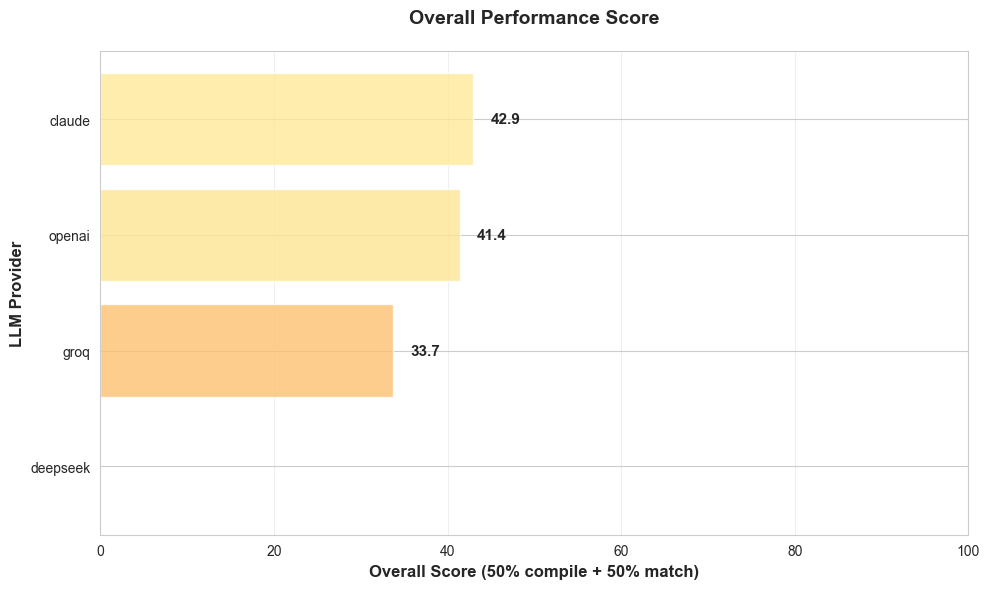


FINAL RANKINGS
1. CLAUDE: 42.9 points
2. OPENAI: 41.4 points
3. GROQ: 33.7 points
4. DEEPSEEK: 0.0 points


In [15]:
# Calculate weighted score:
# 50% weight on compilation rate
# 50% weight on output match rate

scores = {}
for p in providers_list:
    compile_score = results[p]['refactored_pct']
    match_score = results[p]['match_pct']
    overall = (compile_score * 0.5 + match_score * 0.5)
    scores[p] = overall

# Sort by score
sorted_providers = sorted(scores.items(), key=lambda x: x[1], reverse=True)

fig, ax = plt.subplots(figsize=(10, 6))

names = [p[0] for p in sorted_providers]
values = [p[1] for p in sorted_providers]
colors = plt.cm.RdYlGn([v/100 for v in values])

bars = ax.barh(names, values, color=colors, alpha=0.8)

ax.set_xlabel('Overall Score (50% compile + 50% match)', fontsize=12, fontweight='bold')
ax.set_ylabel('LLM Provider', fontsize=12, fontweight='bold')
ax.set_title('Overall Performance Score', fontsize=14, fontweight='bold', pad=20)
ax.set_xlim(0, 100)
ax.grid(axis='x', alpha=0.3)
ax.invert_yaxis()

# Add value labels
for bar, value in zip(bars, values):
    if value > 0:
        ax.text(value + 2, bar.get_y() + bar.get_height()/2,
               f'{value:.1f}',
               va='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("FINAL RANKINGS")
print("="*60)
for i, (provider, score) in enumerate(sorted_providers, 1):
    print(f"{i}. {provider.upper()}: {score:.1f} points")

## Export Results

In [16]:
# Save summary to CSV
df_export = pd.DataFrame(results).T
df_export.to_csv('experiment_results_summary.csv')
print("✓ Results exported to experiment_results_summary.csv")

✓ Results exported to experiment_results_summary.csv
